# モジュール

In [ ]:
from google.colab import drive
drive.mount('./drive')
drive_root_dir="./drive/My Drive/aaaaaa"
import os
!ls
os.chdir(drive_root_dir)

Mounted at ./drive
drive  sample_data


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
import os
import cv2
import random
import time
from PIL import Image
from tqdm import tqdm
import tensorflow as tf
import image_rotate as tfa
from datetime import datetime
import re
import scipy.ndimage as ndimage
from skimage import data, img_as_float
from skimage.restoration import denoise_nl_means, estimate_sigma
from skimage.metrics import peak_signal_noise_ratio
from skimage.util import random_noise
from skimage.restoration import unwrap_phase
from skimage import io, color, filters
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, Input, Activation, BatchNormalization, Dense, MaxPooling2D, Conv2DTranspose

# 自作関数

In [ ]:
output_gif = "animated.gif"

In [ ]:
def save_gif(dir, flame=1000,loop=0):
    image_folder = dir + "/images"
    output_dir = os.path.join(dir, "animation.gif")
    # 拡張子が .png または .tif の画像を読み込む（昇順でソート）
    image_files = sorted([f for f in os.listdir(image_folder) if f.endswith(('.png', '.tif', '.jpg'))],
                         key=extract_number)

    # フルパスに変換して画像を読み込み
    images = [Image.open(os.path.join(image_folder, f)) for f in image_files]

    # GIFとして保存（ループあり、各フレーム200ms）
    images[0].save(output_dir,
                save_all=True,
                append_images=images[1:],
                duration=flame,   # 各フレーム表示時間（ms）
                loop=loop)

# 数値をキーにして自然順でソート
def extract_number(filename):
    match = re.search(r'\d+', filename)
    return int(match.group()) if match else -1

# 2次元配列を画像で保存する関数
def save_tif(data,title,path):
    data=Image.fromarray(data)
    data.save("./"+ path + "/" + title + ".tif")

# 最終的な推定画像に使う合成開口のローパスフィルター
def lowpass(img):
    return abs(np.fft.ifft2(np.fft.ifftshift( AS_mask * np.fft.fftshift(np.fft.fft2(img)) )))

# ガウシアンノイズを与える関数
def addGaussianNoise(src):
    row,col= src.shape
    mean = 0
    sigma = np.sqrt(src)
    gauss = np.random.normal(mean,sigma,(row,col))
    gauss = gauss.reshape(row,col)
    noisy = src + gauss
    return noisy

# 2Dフーリエ変換
def FT(f):
    return np.fft.fftshift(np.fft.fft2(np.fft.fftshift(f)))

# 2D逆フーリエ変換
def iFT(f):
    return np.fft.fftshift(np.fft.ifft2(np.fft.fftshift(f)))

# 平面波展開（TensorFlow用）
def ASM_tf(input_field, pixel_size, dz, xlambda):
    input_shape = input_field.shape
    # 周波数座標
    dfx = 1.0 / (pixel_size * input_shape[1])
    dfy = 1.0 / (pixel_size * input_shape[0])
    fx = np.arange(-input_shape[1] / 2, input_shape[1] / 2) * dfx
    fy = np.arange(-input_shape[0] / 2, input_shape[0] / 2) * dfy
    fx = tf.constant(fx, dtype=tf.float32)
    fy = tf.constant(fy, dtype=tf.float32)
    fx_mesh, fy_mesh = tf.meshgrid(fx, fy)
    fz2 = 1.0 / xlambda ** 2 - fx_mesh ** 2 - fy_mesh ** 2
    fz2 = tf.where(fz2 > 0.0, fz2, 0.0)
    fz = tf.sqrt(fz2)
    # 伝達関数Hの計算
    H_phase = 2 * np.pi * fz * dz
    H = tf.complex(tf.cos(H_phase), tf.sin(H_phase))

    # 伝搬計算本体
    fft_input = tf.signal.fftshift(tf.signal.fft2d(input_field))
    fft_output = fft_input * H
    output = tf.signal.ifft2d(tf.signal.ifftshift(fft_output))
    return output

# Legendre多項式の基底関数を作成する関数．引数：(最大次数，X_mesh, Y_mesh)
def legendre2D( deg, X, Y ):
    m,n     = X.shape
    npol    = int(0.5*(deg+1)*(deg+2))
    B       = np.zeros((npol,m,n))
    for i in np.arange(deg+1):
        for k in np.arange(i+1):
            cx                  = np.random.rand(i+1) * 2 -1
            cy                  = np.random.rand(i+1) * 2 -1
            cx[i-k]             = 1
            cy[k]               = 1
            B[int(i*(i+1)/2)+k] = np.polynomial.legendre.legval(X,cx)*np.polynomial.legendre.legval(Y,cy)
    B[0] = 0*B[0]
    B[1] = 0*B[1]
    B[2] = 0*B[2]
    return B

# Legendre多項式の基底関数を作成する関数．引数：(最大次数，X_mesh, Y_mesh)
def legendreBasis2D( deg, X, Y ):
    m,n     = X.shape
    npol    = int(0.5*(deg+1)*(deg+2))
    B       = np.zeros((npol,m,n))
    for i in np.arange(deg+1):
        for k in np.arange(i+1):
            cx                  = np.zeros(i+1)
            cy                  = np.zeros(i+1)
            cx[i-k]             = 1
            cy[k]               = 1
            B[int(i*(i+1)/2)+k] = np.polynomial.legendre.legval(X,cx)*np.polynomial.legendre.legval(Y,cy)
    B[0] = 0*B[0]
    B[1] = 0*B[1]
    B[2] = 0*B[2]
    return B

# 基底関数と係数から波面を作る関数
def polyEval2D( coef, basis ):
    coef = np.array(coef)
    coef = np.expand_dims(np.expand_dims(coef, -1), -1)
    pupil = np.sum(coef*basis, axis=0)
    # coef = tf.reshape(coef, [-1, 1, 1])
    # pupil = tf.reduce_sum(basis*coef, axis=0)
    return pupil

# 位置ずれ補正用Legendre多項式（１次関数のみ）
def Legendre_shift(z,x,y):
    out = 5*z[0]*(1.7321*x) + \
          5*z[1]*(1.7321*y)
    return out

# SSIMでLossを計算する関数．（普通にMSEなどでlossをとるよりSSIMでとる方が推定がうまくいく場合が多い．）
def ssim_loss(y_true, y_pred):
    ssim = tf.image.ssim(y_true, y_pred, max_val=1, filter_size=11, filter_sigma=3, k1=0.01, k2=0.03 )
    return ssim

def generate_coef_with_norm(norm, mode):
    numbers = np.random.rand(mode) * 2 * norm - norm
    current_norm = np.linalg.norm(numbers)
    numbers = numbers * (norm / current_norm)
    return numbers.tolist()

def pseudo_incoherent(pupil, defocus = 0.0e-6, rot_angle=20, crop_size=256):
    img_total = np.zeros((crop_size, crop_size))
    angle = np.radians(rot_angle)
    angle_num = int(360/rot_angle)
    img_list = []
    for i in range(angle_num):
        rot_A = np.array(tfa.rotate(obA, tf.constant(-1.0*angle)))
        rot_P = np.array(tfa.rotate(obP, tf.constant(-1.0*angle)))
        # コヒーレント結像
        object_img = rot_A * np.exp(rot_P * 1j)
        object_imgFT = np.fft.fftshift(np.fft.fft2(object_img))
        imSeqLowFT = object_imgFT * pupil
        exp_field = np.fft.ifft2(np.fft.ifftshift(imSeqLowFT))

        #デフォーカス付与
        exp_field = ASM_tf(exp_field, pixel_size, defocus, xlambda)
        exp_intensity = np.abs(exp_field)**2

        #ノイズ付与
        scale = np.max(exp_intensity)
        exp_intensity = photon * exp_intensity/scale
        exp_intensity = np.abs(addGaussianNoise(exp_intensity))
        exp_intensity = exp_intensity/photon*scale

        #ノイズ除去
        exp_intensity = np.expand_dims(exp_intensity, axis=-1)
        sigma_est = np.mean(estimate_sigma(exp_intensity, channel_axis=-1))

        patch_kw = dict(
            patch_size=5,  # 5x5 patches
            patch_distance=6,  # 13x13 search area
            channel_axis=-1,
        )
        # fast algorithm, sigma provided
        exp_intensity = denoise_nl_means(
            exp_intensity, h=0.6 * sigma_est, sigma=sigma_est, fast_mode=True, **patch_kw
        )

        #向きをそろえる
        exp_intensity = np.array(tfa.rotate(exp_intensity, tf.constant(i * angle)))
        img_out = exp_intensity[imax//2-int(crop_size//2) : imax//2+int(crop_size//2),
                                jmax//2-int(crop_size//2) : jmax//2+int(crop_size//2)]
        img_list.append(img_out)
        img_total += img_out
    img_total /= np.max(img_total)
    return img_list, img_total


In [ ]:
def FT(f):
    return np.fft.fftshift(np.fft.fft2(np.fft.fftshift(f)))
def iFT(f):
    return np.fft.fftshift(np.fft.ifft2(np.fft.fftshift(f)))

def img_random(img, angle, center, size):
#   error=(random.randrange(-1,2,2)*random.uniform(0,center[0]*5//100),random.randrange(-1,2,2)*random.uniform(0,center[1]*5//100))#位置ずれ
  error=(random.randrange(-1,2,2)*random.uniform(0,center[0]*0),random.randrange(-1,2,2)*random.uniform(0,center[1]*0))#位置ずれなし
  rot_mat = cv2.getRotationMatrix2D((int(center[0]),int(center[1])), angle, 1.0) #cv.getRotationMatrix2D(center回転中心, angle回転角度(度), scale（拡大倍率）)
  rot_mat[0][2] += -center[0]+error[0]+size[0]/2 #（x軸について）-(元画像内での中心位置)+誤差+(切り抜きたいサイズの中心)
  rot_mat[1][2] += -center[1]+error[1]+size[1]/2 #（y軸について）同上
  return cv2.warpAffine(img, rot_mat, size)

def ASM_pytorch(input_field, pixel_size, dz, xlambda):
    # NumPy配列をPyTorchテンソルに変換
    input_field = torch.tensor(input_field, dtype=torch.complex64)

    input_shape = input_field.shape
    # 周波数座標
    dfx = 1.0 / (pixel_size * input_shape[1])
    dfy = 1.0 / (pixel_size * input_shape[0])
    fx = np.arange(-input_shape[1] / 2, input_shape[1] / 2) * dfx
    fy = np.arange(-input_shape[0] / 2, input_shape[0] / 2) * dfy
    fx = torch.tensor(fx, dtype=torch.float32)
    fy = torch.tensor(fy, dtype=torch.float32)
    fx_mesh, fy_mesh = torch.meshgrid(fx, fy)
    fz2 = 1.0 / xlambda ** 2 - fx_mesh ** 2 - fy_mesh ** 2
    fz2 = torch.where(fz2 > 0.0, fz2, torch.tensor(0.0))
    fz = torch.sqrt(fz2)
    # 伝達関数Hの計算
    H_phase = 2 * np.pi * fz * dz
    H = torch.complex(torch.cos(H_phase), torch.sin(H_phase))

    # 伝搬計算本体
    fft_input = torch.fft.fftshift(torch.fft.fft2(input_field))
    fft_output = fft_input * H
    output = torch.fft.ifft2(torch.fft.ifftshift(fft_output))

    # PyTorchテンソルをNumPy配列に変換して返す
    return output.cpu().numpy()

def addGaussianNoise(src):
    row,col= src.shape
    mean = 0
    sigma = np.sqrt(src)
    gauss = np.random.normal(mean,sigma,(row,col))
    gauss = gauss.reshape(row,col)
    noisy = src + gauss
    return noisy

def noise(exp_intensity,photon):
    scale = np.max(exp_intensity)
    exp_intensity = photon * exp_intensity/scale
    exp_intensity = np.abs(addGaussianNoise(exp_intensity))
    exp_intensity = exp_intensity/photon*scale
    return exp_intensity

def applyGaussianBlur(src, sigma):
    # Apply Gaussian filter using scipy
    blurred = gaussian_filter(src, sigma=sigma)
    return blurred

def defocus_noise(max_value, error_rate):
    """
    スカラー値に指定された割合のランダムな誤差を追加する。

    Parameters:
    value (float): 元のスカラー値
    error_rate (float): 誤差の割合 (デフォルトは2%)

    Returns:
    float: 誤差を追加した値
    """
    # ノイズを生成
    noise = np.random.normal(0, error_rate)

    # ノイズを追加
    value_with_error = max_value*noise

    return value_with_error

def img_save(img,name,folder):
  if not os.path.exists(folder):  # ディレクトリが存在しない場合、作成する。
    os.makedirs(folder)
  Image.fromarray(img).save(folder+"/"+name+".tif")

def Legendre_aberration(z,x,y):

    if len(z) != 21:
        z.extend([0.0 for i in range(21-len(z))])
    out = 0*z[0] + \
          0*z[1]*(1.7321*x) + \
          0*z[2]*(1.7321*y) + \
          z[3]*(3.3541*x**2-1.1180) + \
          z[4]*(3.0*x*y) + \
          z[5]*(3.3541*y**2-1.1180) + \
          z[6]*(6.6144*x**3-3.9686*x) + \
          z[7]*(5.8095*y*x**2-1.9365*y) + \
          z[8]*(5.8095*x*y**2-1.9365*x) + \
          z[9]*(6.6144*y**3-3.9686*y) + \
          z[10]*(13.125*x**4-11.25*x**2+1.125) + \
          z[11]*(11.4564*x**3*y-6.8739*x*y) + \
          z[12]*(11.25*x**2*y**2-3.75*x**2-3.75*y**2+1.25) + \
          z[13]*(11.4564*x*y**3-6.8739*x*y) + \
          z[14]*(13.125*y**4-11.25*y**2+1.125) + \
          z[15]*(26.1184*x**5-29.0205*x**3+6.2187*x) + \
          z[16]*(22.7332*x**4*y-19.4856*x**2*y+1.9486*y) + \
          z[17]*(22.1853*x**3*y**2-7.3951*x**3-13.3112*x*y**2+4.4371*x) + \
          z[18]*(22.1853*y**3*x**2-7.3951*y**3-13.3112*y*x**2+4.4371*y) + \
          z[19]*(22.7332*x*y**4-19.4856*x*y**2+1.9486*x) + \
          z[20]*(26.1184*y**5-29.0205*y**3+6.2187*y)
    return out

def Legendre_basis(x,y):
    basis_list = []
    basis_list.append(0*np.ones(x.shape))
    basis_list.append(0*1.7321*x)
    basis_list.append(0*1.7321*y)
    basis_list.append(3.3541*x**2-1.1180)
    basis_list.append(3.0*x*y)
    basis_list.append(3.3541*y**2-1.1180)
    basis_list.append(6.6144*x**3-3.9686*x)
    basis_list.append(5.8095*y*x**2-1.9365*y)
    basis_list.append(5.8095*x*y**2-1.9365*x)
    basis_list.append(6.6144*y**3-3.9686*y)
    basis_list.append(13.125*x**4-11.25*x**2+1.125)
    basis_list.append(11.4564*x**3*y-6.8739*x*y)
    basis_list.append(11.25*x**2*y**2-3.75*x**2-3.75*y**2+1.25)
    basis_list.append(11.4564*x*y**3-6.8739*x*y)
    basis_list.append(13.125*y**4-11.25*y**2+1.125)
    basis_list.append(26.1184*x**5-29.0205*x**3+6.2187*x)
    basis_list.append(22.7332*x**4*y-19.4856*x**2*y+1.9486*y)
    basis_list.append(22.1853*x**3*y**2-7.3951*x**3-13.3112*x*y**2+4.4371*x)
    basis_list.append(22.1853*y**3*x**2-7.3951*y**3-13.3112*y*x**2+4.4371*y)
    basis_list.append(22.7332*x*y**4-19.4856*x*y**2+1.9486*x)
    basis_list.append(26.1184*y**5-29.0205*y**3+6.2187*y)
    return np.array(basis_list)



In [ ]:
def Legendre_basis_6(x, y):
    basis_list = []
    basis_list.append(0*np.ones(x.shape))  # dummy mode 0
    basis_list.append(1.7321*x)
    basis_list.append(1.7321*y)
    basis_list.append(3.3541*x**2-1.1180)
    basis_list.append(3.0*x*y)
    basis_list.append(3.3541*y**2-1.1180)
    basis_list.append(6.6144*x**3-3.9686*x)
    basis_list.append(5.8095*x**2*y-1.9365*y)
    basis_list.append(5.8095*x*y**2-1.9365*x)
    basis_list.append(6.6144*y**3-3.9686*y)
    basis_list.append(13.125*x**4-11.25*x**2+1.125)
    basis_list.append(11.4564*x**3*y-6.8739*x*y)
    basis_list.append(11.25*x**2*y**2 - 3.75*x**2 - 3.75*y**2 + 1.25)
    basis_list.append(11.4564*x*y**3 - 6.8739*x*y)
    basis_list.append(13.125*y**4 - 11.25*y**2 + 1.125)
    basis_list.append(26.1184*x**5 - 29.0205*x**3 + 6.2187*x)
    basis_list.append(22.7332*x**4*y - 19.4856*x**2*y + 1.9486*y)
    basis_list.append(22.1853*x**3*y**2 - 7.3951*x**3 - 13.3112*x*y**2 + 4.4371*x)
    basis_list.append(22.1853*x**2*y**3 - 7.3951*y**3 - 13.3112*x**2*y + 4.4371*y)
    basis_list.append(22.7332*x*y**4 - 19.4856*x*y**2 + 1.9486*x)
    basis_list.append(26.1184*y**5 - 29.0205*y**3 + 6.2187*y)

    basis_list.append(52.0551*x**6 - 70.9843*x**4 + 23.6614*x**2 - 1.1267)  # L_60
    basis_list.append(45.2384*x**5*y - 50.2649*x**3*y + 10.7711*x*y)        # あやふや
    basis_list.append(44.0524*x**4*y**2 - 51.5292*x**2*y**2 + 18.1300*y**2 - 1.0737)  # あやふや
    basis_list.append(37.9628*x**3*y**3 - 30.3709*x*y**3 - 30.3709*x**3*y + 6.0382*x*y)  #あやふや
    basis_list.append(44.0524*x**2*y**4 - 51.5292*x**2*y**2 + 18.1300*x**2 - 1.0737)  # あやふや
    basis_list.append(45.2384*x*y**5 - 50.2649*x*y**3 + 10.7711*x*y)        # あやふや
    basis_list.append(52.0551*y**6 - 70.9843*y**4 + 23.6614*y**2 - 1.1267)  # L_06
    return np.array(basis_list)


In [ ]:
def make_wavefront(coef):# 瞳関数の作成
    pupil = np.array(polyEval2D(coef, B)) * CTF
    # pupil = np.clip(pupil, -np.pi, np.pi)
    pupil = (np.cos(pupil) + 1.0j*np.sin(pupil)) * CTF
    return pupil

def make_wavefront_oblique(coef, theta_x, theta_y, pixel_size=16*1e-9, m=512, NA=1.5e-3, xlambda=(12.4/9.884)*1e-10):# 瞳関数の作成
    aperture = pixel_size * m * 2.0 * np.tan(NA)/xlambda     # [pixel]

    shift_x = pixel_size * m * 2.0 * np.tan(theta_x)/xlambda     # [pixel]
    shift_x = int(shift_x)

    shift_y = pixel_size * m * 2.0 * np.tan(theta_y)/xlambda     # [pixel]
    shift_y = int(shift_y)

    # 開口マスク作成
    CTF = np.zeros((n,m))
    CTF[n//2-int(aperture//2) : n//2 + int(aperture//2),
        m//2-int(aperture//2) : m//2+int(aperture//2)] = 1.0
    # plt.subplot(1,2,1)
    # plt.title("CTF")
    # plt.imshow(CTF)
    # plt.show()
    # plt.imshow(np.array(polyEval2D(coef, B)))
    # plt.colorbar()
    # plt.show()

    pupil = np.array(polyEval2D(coef, B)) * CTF
    # pupil = np.clip(pupil, -np.pi, np.pi)
    pupil = (np.cos(pupil) + 1.0j*np.sin(pupil)) * CTF
    pupil = np.roll(pupil, (shift_x, shift_y), axis = (0, 1))
    return pupil


def ssim_culc(pupil, angle = 2*np.pi/4):
    rot_A = np.array(tfa.rotate(obA, tf.constant(-1.0*0)))
    rot_P = np.array(tfa.rotate(obP, tf.constant(-1.0*0)))
    # コヒーレント結像
    object_img = rot_A * np.exp(rot_P * 1j)
    object_imgFT = np.fft.fftshift(np.fft.fft2(object_img))
    imSeqLowFT = object_imgFT * pupil
    exp_field = np.fft.ifft2(np.fft.ifftshift(imSeqLowFT))
    exp_intensity = np.abs(exp_field)**2
    img_out = np.sqrt(exp_intensity)
    img_out = img_out #[imax//2-int(363//2) : imax//2+int(363//2),jmax//2-int(363//2) : jmax//2+int(363//2)]
    # plt.imshow(img_out,cmap='gray')
    # plt.colorbar()
    # plt.show()

    rot_A = np.array(tfa.rotate(obA, tf.constant(-1.0*angle)))
    rot_P = np.array(tfa.rotate(obP, tf.constant(-1.0*angle)))
    # コヒーレント結像
    object_rot = rot_A * np.exp(rot_P * 1j)
    object_rotFT = np.fft.fftshift(np.fft.fft2(object_rot))
    imSeqLow_rotFT = object_rotFT * pupil
    exp_field_rot = np.fft.ifft2(np.fft.ifftshift(imSeqLow_rotFT))
    exp_intensity_rot = np.abs(exp_field_rot)**2
    img_rot = np.sqrt(exp_intensity_rot)
    img_rot = img_rot #[imax//2-int(363//2) : imax//2+int(363//2),jmax//2-int(363//2) : jmax//2+int(363//2)]
    img_rot = np.array(tfa.rotate(img_rot, tf.constant(angle)))
    # plt.imshow(img_rot,cmap='gray')
    # plt.colorbar()
    # plt.show()
    img_cul0 = tf.expand_dims(img_out, axis=-1)
    img_cul1 = tf.expand_dims(img_rot, axis=-1)
    score = ssim_loss(img_cul0, img_cul1).numpy()
    return score.item()

def rms_calculate(pupil):
  return np.sqrt(np.mean(np.angle(pupil[n//2-int(aperture//2) : n//2+int(aperture//2),m//2-int(aperture//2) : m//2+int(aperture//2)])**2))

# シミュレーション条件の設定

In [ ]:
m = 512                 # 画像サイズ（横）
n = 512                 # 画像サイズ（縦）
rot_angle = 2*np.pi/90   # 1step回転角度
noise_flag = True       # ノイズを付与するかどうかのflag

xlambda = (12.4/9.884)*1e-10               # 波長. [m]
pixel_size = 16*1e-9                       # ピクセルサイズ. [m]
NA = 1.5e-3
thickness = 500.0e-9                       # スターチャート厚み. [m]
refraction = -1.96838E-05+4.074499E-06j    # 屈折率．Ta:9.884keV
coef_w = 4.0     # Legendre多項式の係数幅

photon = 500      # 光子数
max_shift = 6     # 位置ズレ最大. [pixel]
max_defocus = 50  # 最大面ブレ量. [um]

maxD    = 5                    # Legendre多項式の最大次数
mode = (maxD+1)*(maxD+2)//2     # Legendre modeの数
print("Legendre dimension, mode : ", str(maxD) + ", " + str(mode))

coef = [random.uniform(0.0, coef_w)-coef_w/2 for i in range(mode)]   # Legendre多項式の係数

epoch = 3000    # 学習エポック数
tp = 100        # 描画エポック数
lr = 0.1        # 学習率

Legendre dimension, mode :  5, 21


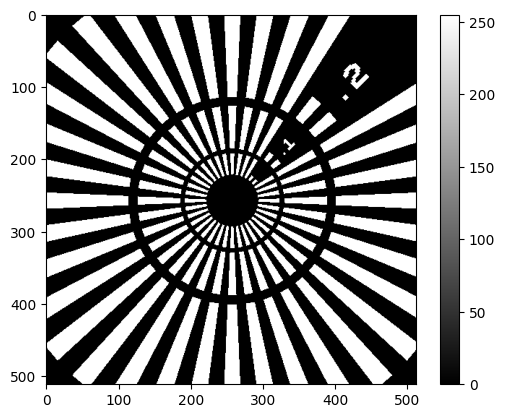

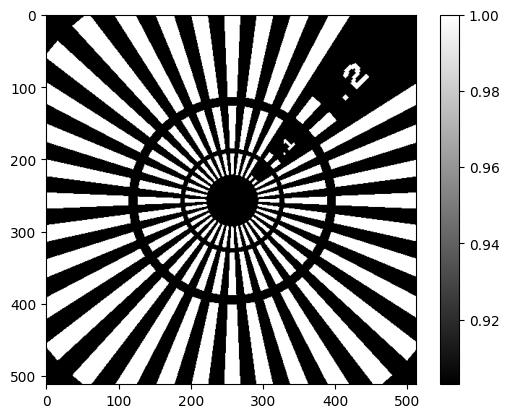

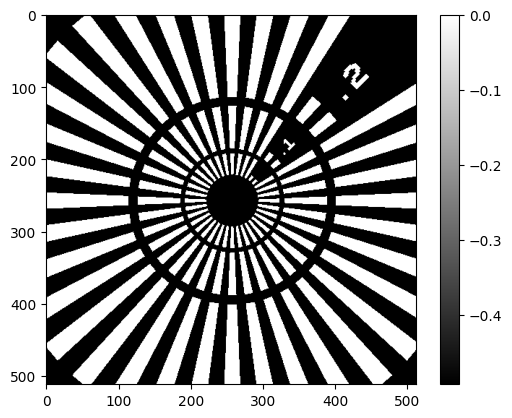

aperture [pix] :  195


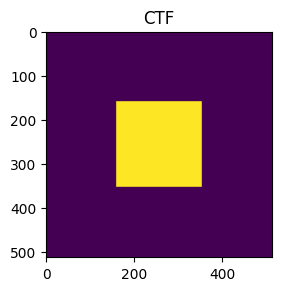

In [ ]:
# スターチャート画像の読み込み
img = np.array(Image.open("./50nm_star_512pix.tif"))
plt.imshow(img, cmap="gray")
plt.colorbar()
plt.show()
imax, jmax = img.shape
object_img = (img) / np.max(img)
object_img = np.where(object_img==0 , np.exp(1.0j * 2.0 * np.pi / xlambda * refraction * thickness), 1.0)
obA = np.abs(object_img)
obP = np.angle(object_img)
plt.imshow(obA,cmap="gray")
plt.colorbar()
plt.show()
plt.imshow(obP,cmap="gray")
plt.colorbar()
plt.show()

# 開口サイズの計算
aperture = pixel_size * m * 2.0 * np.tan(NA)/xlambda     # [pixel]
print("aperture [pix] : ", int(aperture))
seq = np.linspace(-1.0*n/aperture, 1.0*n/aperture, int(n))


# 開口マスク作成
CTF = np.zeros((n,m))
CTF[n//2-int(aperture//2) : n//2+int(aperture//2),
    m//2-int(aperture//2) : m//2+int(aperture//2)] = 1.0
plt.subplot(1,2,1)
plt.title("CTF")
plt.imshow(CTF)
plt.show()



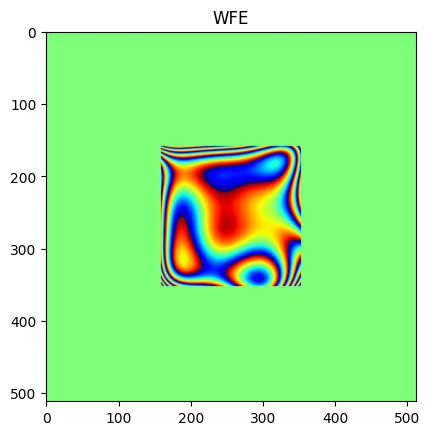

In [ ]:
# Legendre波面作成用メッシュグリッド
[x, y] = np.meshgrid(np.linspace(-1.0*n/aperture, 1.0*n/aperture, int(n)), np.linspace(-1.0*m/aperture, 1.0*m/aperture, int(m)))

# Legendre多項式の基底関数
B = legendreBasis2D(maxD, x, y)
B = Legendre_basis(x,y)

# 瞳関数の作成
pupil = np.array(polyEval2D(coef, B)) * CTF
pupil = (np.cos(pupil) + 1.0j*np.sin(pupil)) * CTF
plt.title("WFE")
plt.imshow(np.angle(pupil),cmap="jet")
plt.show()

# 平面波展開用メッシュグリッド（解析時）
dfx = 1.0 / (pixel_size * m)
dfy = 1.0 / (pixel_size * n)
fx = np.arange(-m/2, m/2) * dfx
fy = np.arange(-n/2, n/2) * dfy
fx = tf.constant(fx, dtype=tf.float32)
fy = tf.constant(fy, dtype=tf.float32)
fx_mesh, fy_mesh = tf.meshgrid(fx, fy)
fz2 = 1.0 / xlambda ** 2 - fx_mesh ** 2 - fy_mesh ** 2
fz2 = tf.where(fz2 > 0.0, fz2, 0.0)
fz = tf.sqrt(fz2)

B = Legendre_basis_6(x, y)

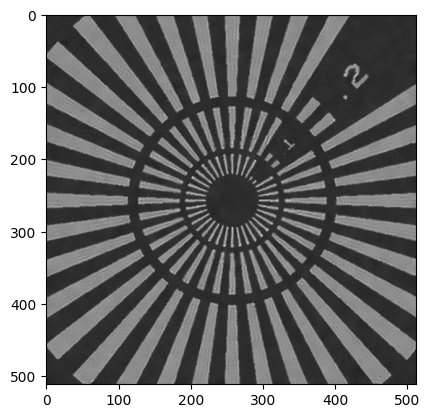

In [ ]:
coef = [0.0] * 28
pupil = make_wavefront_oblique(coef, 0.0e-4, 0.0e-4)
# コヒーレント結像
object_img = obA * np.exp(obP * 1j)
object_imgFT = np.fft.fftshift(np.fft.fft2(object_img))
imSeqLowFT = object_imgFT * pupil
exp_field = np.fft.ifft2(np.fft.ifftshift(imSeqLowFT))
exp_intensity = np.abs(exp_field)**2
scale = np.max(exp_intensity)
exp_intensity = photon * exp_intensity/scale
exp_intensity = np.abs(addGaussianNoise(exp_intensity))
exp_intensity = exp_intensity/photon*scale

#ノイズ除去
exp_intensity = np.expand_dims(exp_intensity, axis=-1)
sigma_est = np.mean(estimate_sigma(exp_intensity, channel_axis=-1))

patch_kw = dict(
        patch_size=5,  # 5x5 patches
        patch_distance=6,  # 13x13 search area
        channel_axis=-1,
    )

    # fast algorithm, sigma provided
exp_intensity = denoise_nl_means(
        exp_intensity, h=0.6 * sigma_est, sigma=sigma_est, fast_mode=True, **patch_kw
    )

plt.imshow(exp_intensity,cmap='gray')
plt.show()

# 評価関数

In [ ]:
import scipy.ndimage as ndimage
def ssim_culc2_8(pupil, rot_angle = 45):
    img_list = []
    angle = 2*np.pi/(360/rot_angle)
    angle_num = int(360/rot_angle)

    for i in range(angle_num):
      rot_A = np.array(tfa.rotate(obA, tf.constant(-1.0 * i * angle)))
      rot_P = np.array(tfa.rotate(obP, tf.constant(-1.0 * i * angle)))
      # コヒーレント結像
      object_img = rot_A * np.exp(rot_P * 1j)
      object_imgFT = np.fft.fftshift(np.fft.fft2(object_img))
      imSeqLowFT = object_imgFT * pupil
      exp_field = np.fft.ifft2(np.fft.ifftshift(imSeqLowFT))
      exp_intensity = np.abs(exp_field)**2
      scale = np.max(exp_intensity)
      exp_intensity = photon * exp_intensity/scale
      exp_intensity = np.abs(addGaussianNoise(exp_intensity))
      exp_intensity = exp_intensity/photon*scale
      exp_intensity = np.array(tfa.rotate(exp_intensity, tf.constant(i * angle)))
      img_out = exp_intensity[imax//2-int(363//2) : imax//2+int(363//2),jmax//2-int(363//2) : jmax//2+int(363//2)]
      # img_out = ndimage.median_filter(img_out, size=3)
      img_out = ndimage.gaussian_filter(img_out, sigma=1.0)
      # plt.imshow(img_out,cmap='gray')
      # plt.colorbar()
      # plt.show()
      img_list.append(tf.expand_dims(img_out, axis=-1))
      ssim_list = np.array([])
    for i in range(7):
      ssim = tf.image.ssim(img_list[0], img_list[i+1], max_val=1, filter_size=11, filter_sigma=3, k1=0.01, k2=0.03 )
      ssim_list = np.append(ssim_list, ssim.numpy())
    return float(np.mean(ssim_list))


In [ ]:
def ssim_culc2_8(pupil, rot_angle = 45):
    ssim_list = np.array([])
    angle = 2*np.pi/(360/rot_angle)
    rot_A = np.array(tfa.rotate(obA, tf.constant(-1.0 * 0.0)))
    rot_P = np.array(tfa.rotate(obP, tf.constant(-1.0 * 0.0)))
    # コヒーレント結像
    object_img = rot_A * np.exp(rot_P * 1j)
    object_imgFT = np.fft.fftshift(np.fft.fft2(object_img))
    imSeqLowFT = object_imgFT * pupil
    exp_field = np.fft.ifft2(np.fft.ifftshift(imSeqLowFT))
    exp_intensity = np.abs(exp_field)**2
    scale = np.max(exp_intensity)
    exp_intensity = photon * exp_intensity/scale
    exp_intensity = np.abs(addGaussianNoise(exp_intensity))
    exp_intensity = exp_intensity/photon*scale

    #ノイズ除去
    exp_intensity = np.expand_dims(exp_intensity, axis=-1)
    sigma_est = np.mean(estimate_sigma(exp_intensity, channel_axis=-1))

    patch_kw = dict(
        patch_size=5,  # 5x5 patches
        patch_distance=6,  # 13x13 search area
        channel_axis=-1,
    )

    # fast algorithm, sigma provided
    exp_intensity = denoise_nl_means(
        exp_intensity, h=0.6 * sigma_est, sigma=sigma_est, fast_mode=True, **patch_kw
    )

    img_out = exp_intensity[imax//2-int(128//2) : imax//2+int(128//2),jmax//2-int(128//2) : jmax//2+int(128//2)]
    img_out = ndimage.median_filter(img_out, size=3)
    img_culc = tf.expand_dims(img_out, axis=-1)
    # img_out = ndimage.gaussian_filter(img_out, sigma=1.0)
    # plt.imshow(img_out,cmap='gray')
    # plt.colorbar()
    # plt.show()

    rot_A = np.array(tfa.rotate(obA, tf.constant(-1.0 * angle)))
    rot_P = np.array(tfa.rotate(obP, tf.constant(-1.0 * angle)))
    # コヒーレント結像
    object_img = rot_A * np.exp(rot_P * 1j)
    object_imgFT = np.fft.fftshift(np.fft.fft2(object_img))
    imSeqLowFT = object_imgFT * pupil
    exp_field = np.fft.ifft2(np.fft.ifftshift(imSeqLowFT))
    exp_intensity = np.abs(exp_field)**2
    scale = np.max(exp_intensity)
    exp_intensity = photon * exp_intensity/scale
    exp_intensity = np.abs(addGaussianNoise(exp_intensity))
    exp_intensity = exp_intensity/photon*scale

    #ノイズ除去
    exp_intensity = np.expand_dims(exp_intensity, axis=-1)
    sigma_est = np.mean(estimate_sigma(exp_intensity, channel_axis=-1))

    patch_kw = dict(
        patch_size=5,  # 5x5 patches
        patch_distance=6,  # 13x13 search area
        channel_axis=-1,
    )

    # fast algorithm, sigma provided
    exp_intensity = denoise_nl_means(
        exp_intensity, h=0.6 * sigma_est, sigma=sigma_est, fast_mode=True, **patch_kw
    )

    exp_intensity = np.array(tfa.rotate(exp_intensity, tf.constant(angle)))
    img_out2 = exp_intensity[imax//2-int(128//2) : imax//2+int(128//2),jmax//2-int(128//2) : jmax//2+int(128//2)]
    img_out2 = ndimage.median_filter(img_out2, size=3)
    # img_out = ndimage.gaussian_filter(img_out, sigma=1.0)
    img_culc2 = tf.expand_dims(img_out2, axis=-1)
    ssim = tf.image.ssim(img_culc, img_culc2, max_val=1, filter_size=11, filter_sigma=1.5, k1=0.01, k2=0.03 )
    # print(ssim.numpy())
    return ssim.numpy()

In [ ]:
def ssim_culc2_8_filter(pupil,rot_angle=20,crop_size=256):
  img_total = np.zeros((crop_size, crop_size))
  angle = 2*np.pi/(360/rot_angle)
  angle_num = int(360/rot_angle)
  img_list = []
  angle_list=[]
  for i in range(angle_num):
    angle_list.append(i*rot_angle)
    rot_A = np.array(tfa.rotate(obA, tf.constant(-1.0 * i * angle)))
    rot_P = np.array(tfa.rotate(obP, tf.constant(-1.0 * i * angle)))
    # コヒーレント結像
    object_img = rot_A * np.exp(rot_P * 1j)
    object_imgFT = np.fft.fftshift(np.fft.fft2(object_img))
    imSeqLowFT = object_imgFT * pupil
    exp_field = np.fft.ifft2(np.fft.ifftshift(imSeqLowFT))

    # 面ブレを考慮したデフォーカスを与える．
    dz = -40.0 *1e-6
    exp_field = ASM_tf(exp_field, pixel_size, dz, xlambda)


    exp_intensity = np.abs(exp_field)**2
    scale = np.max(exp_intensity)
    exp_intensity = photon * exp_intensity/scale
    exp_intensity = np.abs(addGaussianNoise(exp_intensity))
    exp_intensity = exp_intensity/photon*scale

    # exp_intensity = ndimage.median_filter(exp_intensity)

    #ノイズ除去
    exp_intensity = np.expand_dims(exp_intensity, axis=-1)
    sigma_est = np.mean(estimate_sigma(exp_intensity, channel_axis=-1))

    patch_kw = dict(
        patch_size=5,  # 5x5 patches
        patch_distance=6,  # 13x13 search area
        channel_axis=-1,
    )

    # fast algorithm, sigma provided
    exp_intensity = denoise_nl_means(
        exp_intensity, h=0.6 * sigma_est, sigma=sigma_est, fast_mode=True, **patch_kw
    )

    exp_intensity = np.array(tfa.rotate(exp_intensity, tf.constant(i * angle)))
    img_out = exp_intensity[imax//2-int(crop_size//2) : imax//2+int(crop_size//2),
                            jmax//2-int(crop_size//2) : jmax//2+int(crop_size//2)]
    img_list.append(img_out)
    img_total += img_out
  img_total /= angle_num
  # plt.imshow(img_total, cmap="gray")
  # plt.colorbar()
  # plt.show()


  #スコアの計算
  score_list=[]
  img_total_culc = tf.expand_dims(img_total, axis=-1)

  for img in img_list:
    img_culc = tf.expand_dims(img, axis=-1)
    score = tf.image.ssim(img_total_culc, img_culc, max_val=1, filter_size=11, filter_sigma=1.5, k1=0.01, k2=0.03)
    score_list.append(score.numpy())
  score_arr = np.array(score_list)
  score_sigma = np.std(score_arr)
  return np.mean(score_list)

  #コントラスト計算
  # img_dif = cv2.Laplacian(img_total, cv2.CV_64F)
  # cont = np.std(np.abs(img_dif))
  # return cont



In [ ]:
def laplacian_score(img):
  img_diff = cv2.Laplacian(img, cv2.CV_64F)
  score = np.std(np.abs(img_diff))
  return score

In [ ]:
colors = ['blue'] * 28
colors[3], colors[5] = 'red','red'
colors[6], colors[9] = 'blue', 'blue'
colors[10], colors[14] = 'green', 'green'
colors[15], colors[20] = 'yellow', 'yellow'
colors[21], colors[27] = 'purple', 'purple'

In [ ]:
# colors = ['blue'] * 21
# colors[3], colors[5] = 'red','red'
# colors[6], colors[9] = 'blue', 'blue'
# colors[10], colors[14] = 'green', 'green'
# colors[15], colors[20] = 'yellow', 'yellow'

# SPGD

In [ ]:
def find_numbers_with_norm(norm, num, limit):
    numbers = [2*limit*random.random() - limit for _ in range(num)]
    numbers = np.array(numbers)
    current_norm = np.linalg.norm(numbers)
    numbers = numbers * (norm / current_norm)
    return numbers.tolist()

def SPGD(limit, iterations=100, rate=0.5, num=10, rho=0.99, lr = 10):
    alpha = (1-rho)**(1/iterations)
    delta = ([0.0] *28)
    blur_list = []
    rms_list = []
    eta_culc = None
    global coef
    for step in range(iterations):
        if step % 20 == 0:
          print(f'step{step}')
        delta[3], delta[5], delta[6], delta[9], delta[10], delta[14], delta[15], delta[20], delta[21], delta[27]= find_numbers_with_norm(rate, num, limit) #delta[3], delta[5],
        coef_delta1 = np.array(coef) + delta
        coef_delta1 = coef_delta1.tolist()
        coef_delta2 = np.array(coef) - delta
        coef_delta2 = coef_delta2.tolist()

        #差分を計算
        pupil_delta2 = make_wavefront_oblique(coef_delta2, theta_x, theta_y)
        pupil_delta1 = make_wavefront_oblique(coef_delta1, theta_x, theta_y)
        score_delta2 = ssim_culc2_8_filter(pupil_delta2)
        score_delta1 = ssim_culc2_8_filter(pupil_delta1)
        diffusion = score_delta1 - score_delta2
        print(f'diffusion{diffusion}')

        if eta_culc != None:
            eta = 5.0*(0.035-eta_culc)/eta_culc
            if eta > 10:
              eta = 10
            if eta < 1.0:
              eta=1.0
            print(f'eta {eta}')
        else:
            eta = 1.0
        # eta = 0.5

        # coef = np.array(coef) + (diffusion/np.abs(diffusion)) * np.array(delta)
        # coef = coef.tolist()
        # print(f'変化量 {eta * (diffusion/(2 * rate)) *( np.array(delta)/rate)}')
        coef = np.array(coef) + eta * (diffusion/(2 * rate)) *( np.array(delta)/rate)
        coef = coef.tolist()


        for coef_p in (coef):
            if abs(coef_p) > limit:
                coef[coef.index(coef_p)] = 2*limit*random.random() - limit

        #計算
        pupil = make_wavefront_oblique(coef, theta_x, theta_y)
        score = ssim_culc2_8_filter(pupil)
        rms = rms_calculate(pupil)
        print(score)
        eta_culc = np.max([score_delta1, score_delta2])

        #グラフ＋画像
        blur_list.append(score)
        rms_list.append(rms)
        plt.bar(range(1, 1+len(coef)), coef, color=colors)
        plt.ylim(-2.0,2.0)
        plt.axhline(y=0, color='gray', linestyle='-', linewidth=1)
        imgName = f"{step}_graph_{score}.tif"
        filename = os.path.join(save_images, imgName)
        plt.savefig(filename, dpi = 300, format= 'tiff')
        plt.close()
        if score > 0.85:
          break
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    ax1.plot(blur_list, color='blue')
    ax2.plot(rms_list, color='red')
    imgName = f"blur.tif"
    filename = os.path.join(save_dir, imgName)
    plt.savefig(filename, dpi = 300, format= 'tiff')
    plt.show()


In [ ]:
coef_w = 4     # Legendre多項式の係数幅
limit = coef_w/2
maxD    = 6                    # Legendre多項式の最大次数
mode = (maxD+1)*(maxD+2)//2     # Legendre modeの数
print("Legendre dimension, mode : ", str(maxD) + ", " + str(mode))

target = [random.uniform(0.0, coef_w)-coef_w/2 for i in range(10)]   # Legendre多項式の係数
coef = [0.0] * mode
coef[3], coef[5], coef[6], coef[9], coef[10], coef[14], coef[15], coef[20],coef[21], coef[27] = target
# coef[3], coef[5] = 0.0, 0.0
# coef = [0.0, 0.0, 0.0, -0.6197761341664599, 0.0, 0.7634732979794046, -1.056283131300209, 0.0, 0.0, -1.0694038003483282, 0.3427425538614828, 0.0, 0.0, 0.0, -0.4051321174458795, -1.0287290706076822, 0.0, 0.0, 0.0, 0.0, -1.061066032404548, -0.2874312708235407, 0.0, 0.0, 0.0, 0.0, 0.0, 1.1379885046164149]
# coef[4] = 0.2
print("coef",coef)
B = Legendre_basis_6(x, y)
if maxD ==4:
  B=B[:15]

start_coef = coef
print(target, len(target))
print(coef)

Legendre dimension, mode :  6, 28
coef [0.0, 0.0, 0.0, -0.28514874307702476, 0.0, 0.8102648456149311, -0.9531597702589085, 0.0, 0.0, -1.9647140263366896, -0.21731321634334355, 0.0, 0.0, 0.0, -0.8524624097971341, 0.3505341486452762, 0.0, 0.0, 0.0, 0.0, -1.123776231503598, -1.718645348171293, 0.0, 0.0, 0.0, 0.0, 0.0, 0.8597463375894292]
[-0.28514874307702476, 0.8102648456149311, -0.9531597702589085, -1.9647140263366896, -0.21731321634334355, -0.8524624097971341, 0.3505341486452762, -1.123776231503598, -1.718645348171293, 0.8597463375894292] 10
[0.0, 0.0, 0.0, -0.28514874307702476, 0.0, 0.8102648456149311, -0.9531597702589085, 0.0, 0.0, -1.9647140263366896, -0.21731321634334355, 0.0, 0.0, 0.0, -0.8524624097971341, 0.3505341486452762, 0.0, 0.0, 0.0, 0.0, -1.123776231503598, -1.718645348171293, 0.0, 0.0, 0.0, 0.0, 0.0, 0.8597463375894292]


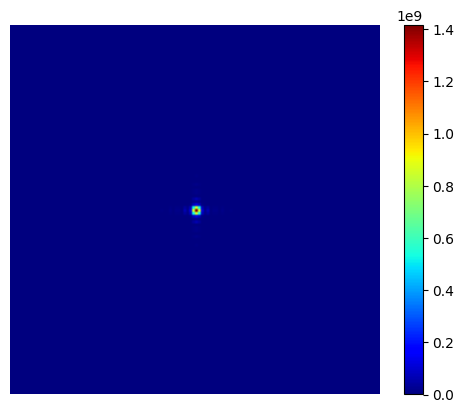

In [ ]:


pupil = make_wavefront_oblique([0.0]*28, theta_x, theta_y)
exp_field = np.fft.fftshift(np.fft.fft2(np.fft.fftshift(pupil)))
exp_intensity = np.abs(exp_field)**2
imgName = "start_psf.tif"
filename = os.path.join(save_dir, imgName)
plt.imshow(exp_intensity[imax//2-64:imax//2+64,imax//2-64:imax//2+64], cmap="jet",vmax = np.max(exp_intensity))
plt.axis("off")
plt.colorbar()
plt.show()

[0.0, 0.0, 0.0, -0.28514874307702476, 0.0, 0.8102648456149311, -0.9531597702589085, 0.0, 0.0, -1.9647140263366896, -0.21731321634334355, 0.0, 0.0, 0.0, -0.8524624097971341, 0.3505341486452762, 0.0, 0.0, 0.0, 0.0, -1.123776231503598, -1.718645348171293, 0.0, 0.0, 0.0, 0.0, 0.0, 0.8597463375894292]


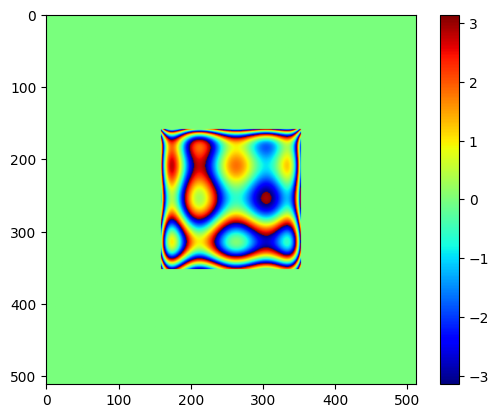

20250617_050441
[0.0, 0.0, 0.0, -0.28514874307702476, 0.0, 0.8102648456149311, -0.9531597702589085, 0.0, 0.0, -1.9647140263366896, -0.21731321634334355, 0.0, 0.0, 0.0, -0.8524624097971341, 0.3505341486452762, 0.0, 0.0, 0.0, 0.0, -1.123776231503598, -1.718645348171293, 0.0, 0.0, 0.0, 0.0, 0.0, 0.8597463375894292]


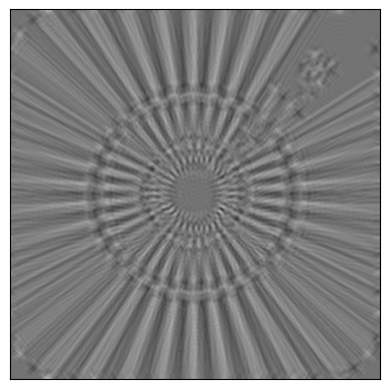

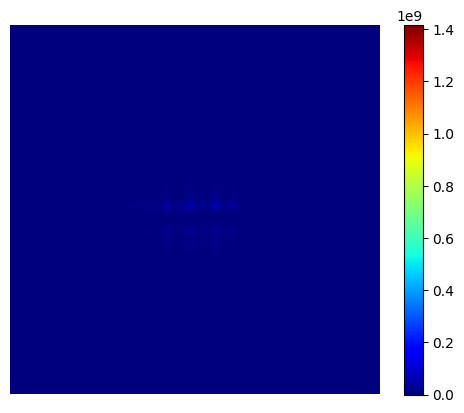

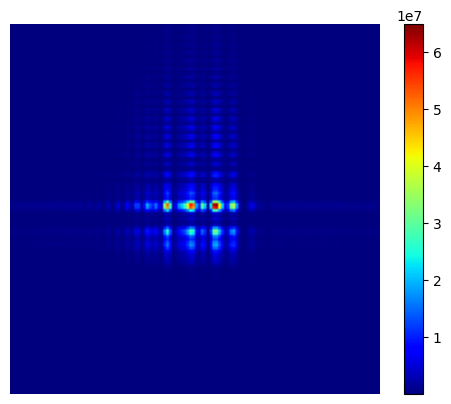

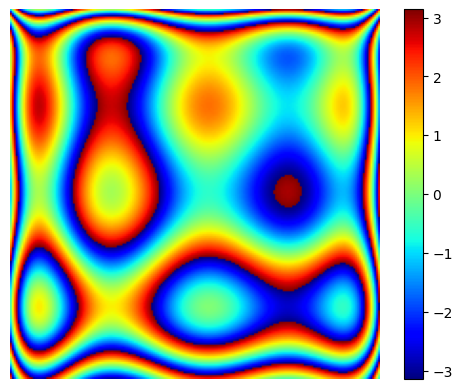

In [ ]:
# coef = [0.0, 0.0, 0.0, -1.2514339588855623, 0.0, -0.3144071409557081, -0.8010882969276838, 0.0, 0.0, 1.3111189862683834, 0.35207777395103856, 0.0, 0.0, 0.0, -0.28724129164016254, -1.4398127181549492, 0.0, 0.0, 0.0, 0.0, 0.15651562780177164, 1.0270377425221868, 0.0, 0.0, 0.0, 0.0, 0.0, -0.05356897336279265]

print(coef)
theta_x = 0.0e-4
theta_y = 0.0e-4
pupil = make_wavefront_oblique(coef, theta_x, theta_y)
plt.imshow(np.angle(pupil),cmap="jet")
plt.colorbar()
plt.show()
score = ssim_culc2_8_filter(pupil)

now = datetime.now()
timestamp = now.strftime("%Y%m%d_%H%M%S")
print(timestamp)
save_dir = f"./SPGD_starthenka_{theta_x},{theta_y}_{timestamp}"
save_images = f"{save_dir}/images"
if not os.path.exists(save_images):
  os.makedirs(save_images)

print(coef)
pupil = make_wavefront_oblique(coef, theta_x, theta_y)
pupil0 = make_wavefront(coef)
rms = rms_calculate(pupil0)
rot_A = np.array(tfa.rotate(obA, tf.constant(-1.0*0)))
rot_P = np.array(tfa.rotate(obP, tf.constant(-1.0*0)))
object_img = rot_A * np.exp(rot_P * 1j)
object_imgFT = np.fft.fftshift(np.fft.fft2(object_img))
imSeqLowFT = object_imgFT * pupil
exp_field = np.fft.ifft2(np.fft.ifftshift(imSeqLowFT))
exp_intensity = np.abs(exp_field)**2
img_out = np.sqrt(exp_intensity)
img_out = img_out
imgName = f"start_img_{score}.tif"
filename = os.path.join(save_dir, imgName)
plt.imshow(img_out,cmap='gray',vmin=0, vmax=2.0)
plt.xticks([])
plt.yticks([])
plt.savefig(filename, dpi = 300, format= 'tiff')
plt.show()
exp_field = np.fft.fftshift(np.fft.fft2(np.fft.fftshift(pupil)))
exp_intensity = np.abs(exp_field)**2
imgName = "start_psf.tif"
filename = os.path.join(save_dir, imgName)
plt.imshow(exp_intensity[imax//2-64:imax//2+64,imax//2-64:imax//2+64], cmap="jet",vmin=0, vmax=1416468496.0)
plt.axis("off")
plt.colorbar()
plt.savefig(filename, dpi = 300, format= 'tiff')
plt.show()
imgName = "start_psf2.tif"
filename = os.path.join(save_dir, imgName)
plt.imshow(exp_intensity[imax//2-64:imax//2+64,imax//2-64:imax//2+64], cmap="jet")
plt.axis("off")
plt.colorbar()
plt.savefig(filename, dpi = 300, format= 'tiff')
plt.show()
imgName = f"start_wavefront_{rms}.tif"
filename = os.path.join(save_dir, imgName)
pupil2 = pupil0[imax//2-int(aperture//2):imax//2+int(aperture//2),imax//2-int(aperture//2):imax//2+int(aperture//2)]
plt.imshow(np.angle(pupil2), cmap="jet", vmin=-np.pi, vmax=np.pi)
plt.axis("off")
plt.colorbar()
plt.savefig(filename, dpi = 300, format= 'tiff')
plt.show()

In [ ]:
SPGD(limit, iterations = 250)

print(coef)
pupil = make_wavefront_oblique(coef, theta_x, theta_y)
pupil0 = make_wavefront(coef)
rms = rms_calculate(pupil0)
score = ssim_culc2_8_filter(pupil)
rot_A = np.array(tfa.rotate(obA, tf.constant(-1.0*0)))
rot_P = np.array(tfa.rotate(obP, tf.constant(-1.0*0)))
object_img = rot_A * np.exp(rot_P * 1j)
object_imgFT = np.fft.fftshift(np.fft.fft2(object_img))
imSeqLowFT = object_imgFT * pupil
exp_field = np.fft.ifft2(np.fft.ifftshift(imSeqLowFT))
exp_intensity = np.abs(exp_field)**2
img_out = np.sqrt(exp_intensity)
img_out = img_out
imgName = f"img_{score}.tif"
filename = os.path.join(save_dir, imgName)
plt.imshow(img_out,cmap='gray',vmin=0, vmax=2.0)
plt.xticks([])
plt.yticks([])
plt.savefig(filename, dpi = 300, format= 'tiff')
plt.show()

imgName = f"img_culc_{score}.tif"
filename = os.path.join(save_dir, imgName)
plt.imshow(img_out[imax//2-int(356//2) : imax//2+int(356//2),
                   jmax//2-int(356//2) : jmax//2+int(356//2)],cmap='gray',vmin=0, vmax=2.0)
plt.xticks([])
plt.yticks([])
plt.savefig(filename, dpi = 300, format= 'tiff')
plt.show()

exp_field = np.fft.fftshift(np.fft.fft2(np.fft.fftshift(pupil)))
exp_intensity = np.abs(exp_field)**2
imgName = "psf.tif"
filename = os.path.join(save_dir, imgName)
plt.imshow(exp_intensity[imax//2-64:imax//2+64,imax//2-64:imax//2+64], cmap="jet",vmin=0, vmax=1416468496.0)
plt.axis("off")
plt.colorbar()
plt.savefig(filename, dpi = 300, format= 'tiff')
plt.show()
imgName = "psf2.tif"
filename = os.path.join(save_dir, imgName)
plt.imshow(exp_intensity[imax//2-64:imax//2+64,imax//2-64:imax//2+64], cmap="jet")
plt.axis("off")
plt.colorbar()
plt.savefig(filename, dpi = 300, format= 'tiff')
plt.show()
imgName = f"wavefront_{rms}.tif"
filename = os.path.join(save_dir, imgName)
pupil2 = pupil0[imax//2-int(aperture//2):imax//2+int(aperture//2),imax//2-int(aperture//2):imax//2+int(aperture//2)]
plt.imshow(np.angle(pupil2), cmap="jet", vmin=-np.pi, vmax=np.pi)
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.savefig(filename, dpi = 300, format= 'tiff')
plt.show()
save_gif(save_dir,flame=100)

step0
diffusion0.024743229150772095
0.11539657
diffusion-0.012339010834693909
eta 1.0
0.11578503
diffusion-0.001478143036365509
eta 1.0
0.11555195
diffusion0.019215434789657593
eta 1.0
0.11617234
diffusion-0.037766993045806885
eta 1.0
0.11798142
diffusion-0.012004561722278595
eta 1.0
0.11797195
diffusion0.005323871970176697
eta 1.0
0.11815254
diffusion0.017536140978336334
eta 1.0
0.118764944
diffusion0.016891151666641235
eta 1.0
0.11881355
diffusion-0.02289322018623352
eta 1.0
0.11860827
diffusion0.05097334086894989
eta 1.0
0.123890385
diffusion0.01497410237789154
eta 1.0
0.12393212
diffusion-0.0008699521422386169
eta 1.0
0.12421763
diffusion-0.011786594986915588
eta 1.0
0.12391276
diffusion0.0422261506319046
eta 1.0
0.12607569
diffusion-0.008950434625148773
eta 1.0
0.12631448
diffusion0.02073436975479126
eta 1.0
0.12718454
diffusion-0.044532597064971924
eta 1.0
0.12902728
diffusion0.005434095859527588
eta 1.0
0.12966281
diffusion-0.014757096767425537
eta 1.0
0.13017482
step20
diffusio

In [ ]:
print(coef)#編者無

In [ ]:
print(coef)#編者あり

[0.0, 0.0, 0.0, -0.3031265159748233, 0.0, 0.7806994379010377, 1.548464858189961, 0.0, 0.0, -0.4217797091298186, 1.0479532455760954, 0.0, 0.0, 0.0, 0.38436350267429814, 0.4640245337771528, 0.0, 0.0, 0.0, 0.0, -1.1251267803313867, 0.17229470109724468, 0.0, 0.0, 0.0, 0.0, 0.0, -0.04219170862779768]


In [ ]:
print(coef)#編者あり

[0.0, 0.0, 0.0, -1.680503771678805, 0.0, 0.6713933719274054, 1.6351488936453353, 0.0, 0.0, -0.790211964363365, -0.949955920178731, 0.0, 0.0, 0.0, 1.5032412591053852, -1.2306687574565507, 0.0, 0.0, 0.0, 0.0, 1.238745426686177, -0.39215164554944504, 0.0, 0.0, 0.0, 0.0, 0.0, -0.539616175283201]


# coolmomentum

In [ ]:
def CoolMomentumSPGD(limit, iterations=100, rate=0.5, num=10, rho=0.5, lr = 5):
    alpha = (1-rho)**(1/iterations)
    rho_current = rho
    lr_current = lr
    before = 0.0
    delta = ([0.0] *28)
    blur_list = []
    rms_list = []
    eta_culc = None
    global coef
    for step in range(iterations):
        if step % 20 == 0:
          print(f'step{step}')
        delta[3], delta[5], delta[6], delta[9], delta[10], delta[14], delta[15], delta[20], delta[21], delta[27]= find_numbers_with_norm(rate, num, limit) #delta[3], delta[5],
        coef_delta1 = np.array(coef) + delta
        coef_delta1 = coef_delta1.tolist()
        coef_delta2 = np.array(coef) - delta
        coef_delta2 = coef_delta2.tolist()

        #差分を計算
        pupil_delta2 = make_wavefront_oblique(coef_delta2, theta_x, theta_y)
        pupil_delta1 = make_wavefront_oblique(coef_delta1, theta_x, theta_y)
        score_delta2 = ssim_culc2_8_filter(pupil_delta2)
        score_delta1 = ssim_culc2_8_filter(pupil_delta1)
        diffusion = score_delta1 - score_delta2
        print(f'diffusion{diffusion}')

        delta_coef = rho_current * before + lr_current * diffusion * np.array(delta)
        before = delta_coef
        coef = np.array(coef) + delta_coef
        coef = coef.tolist()


        for coef_p in (coef):
            if abs(coef_p) > limit:
                coef[coef.index(coef_p)] = 2*limit*random.random() - limit
        rho_current = 1 - (1-rho)/(alpha**(step+1))
        lr_current = lr * (1 + rho_current)/2

        #計算
        pupil = make_wavefront_oblique(coef, theta_x, theta_y)
        score = ssim_culc2_8_filter(pupil)
        rms = rms_calculate(pupil)
        print(score)
        eta_culc = np.max([score_delta1, score_delta2])

        #グラフ＋画像
        blur_list.append(score)
        rms_list.append(rms)
        plt.bar(range(1, 1+len(coef)), coef, color=colors)
        plt.ylim(-2.0,2.0)
        plt.axhline(y=0, color='gray', linestyle='-', linewidth=1)
        imgName = f"{step}_graph_{score}.tif"
        filename = os.path.join(save_images, imgName)
        plt.savefig(filename, dpi = 300, format= 'tiff')
        plt.close()
        if score > 0.85:
          break
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    ax1.plot(blur_list, color='blue')
    ax2.plot(rms_list, color='red')
    imgName = f"blur.tif"
    filename = os.path.join(save_dir, imgName)
    plt.savefig(filename, dpi = 300, format= 'tiff')
    plt.show()

In [ ]:
coef_w = 4     # Legendre多項式の係数幅
limit = coef_w/2
maxD    = 6                    # Legendre多項式の最大次数
mode = (maxD+1)*(maxD+2)//2     # Legendre modeの数
print("Legendre dimension, mode : ", str(maxD) + ", " + str(mode))

target = [random.uniform(0.0, coef_w)-coef_w/2 for i in range(10)]   # Legendre多項式の係数
coef = [0.0] * mode
coef[3], coef[5], coef[6], coef[9], coef[10], coef[14], coef[15], coef[20],coef[21], coef[27] = target
# coef[3], coef[5] = 0.0, 0.0
# coef = [0.0, 0.0, 0.0, -0.6197761341664599, 0.0, 0.7634732979794046, -1.056283131300209, 0.0, 0.0, -1.0694038003483282, 0.3427425538614828, 0.0, 0.0, 0.0, -0.4051321174458795, -1.0287290706076822, 0.0, 0.0, 0.0, 0.0, -1.061066032404548, -0.2874312708235407, 0.0, 0.0, 0.0, 0.0, 0.0, 1.1379885046164149]
# coef[4] = 0.2
print("coef",coef)
B = Legendre_basis_6(x, y)
if maxD ==4:
  B=B[:15]

start_coef = coef
print(target, len(target))
print(coef)

Legendre dimension, mode :  6, 28
coef [0.0, 0.0, 0.0, -0.6235902581698158, 0.0, 0.3619195618306086, 1.7238626060108952, 0.0, 0.0, -0.8600697371992703, -1.1434744767685876, 0.0, 0.0, 0.0, -1.1559541944346288, -1.4251240384007606, 0.0, 0.0, 0.0, 0.0, 1.5218494507521538, 0.41420781392607964, 0.0, 0.0, 0.0, 0.0, 0.0, -1.3877953617963326]
[-0.6235902581698158, 0.3619195618306086, 1.7238626060108952, -0.8600697371992703, -1.1434744767685876, -1.1559541944346288, -1.4251240384007606, 1.5218494507521538, 0.41420781392607964, -1.3877953617963326] 10
[0.0, 0.0, 0.0, -0.6235902581698158, 0.0, 0.3619195618306086, 1.7238626060108952, 0.0, 0.0, -0.8600697371992703, -1.1434744767685876, 0.0, 0.0, 0.0, -1.1559541944346288, -1.4251240384007606, 0.0, 0.0, 0.0, 0.0, 1.5218494507521538, 0.41420781392607964, 0.0, 0.0, 0.0, 0.0, 0.0, -1.3877953617963326]


[0.0, 0.0, 0.0, -0.6235902581698158, 0.0, 0.3619195618306086, 1.7238626060108952, 0.0, 0.0, -0.8600697371992703, -1.1434744767685876, 0.0, 0.0, 0.0, -1.1559541944346288, -1.4251240384007606, 0.0, 0.0, 0.0, 0.0, 1.5218494507521538, 0.41420781392607964, 0.0, 0.0, 0.0, 0.0, 0.0, -1.3877953617963326]


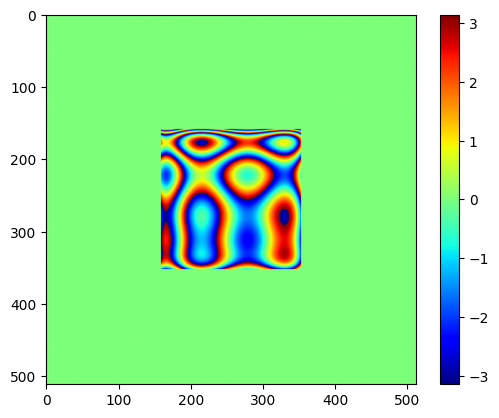

20250606_050005
[0.0, 0.0, 0.0, -0.6235902581698158, 0.0, 0.3619195618306086, 1.7238626060108952, 0.0, 0.0, -0.8600697371992703, -1.1434744767685876, 0.0, 0.0, 0.0, -1.1559541944346288, -1.4251240384007606, 0.0, 0.0, 0.0, 0.0, 1.5218494507521538, 0.41420781392607964, 0.0, 0.0, 0.0, 0.0, 0.0, -1.3877953617963326]


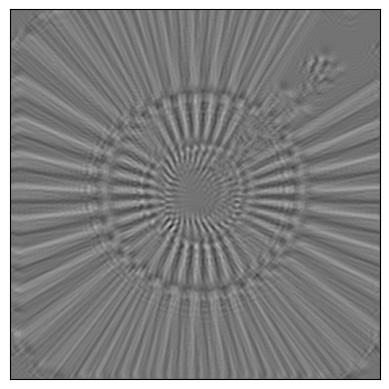

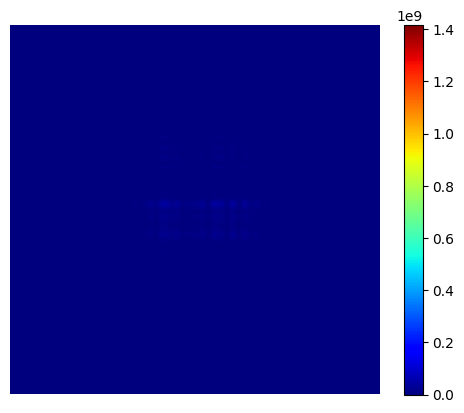

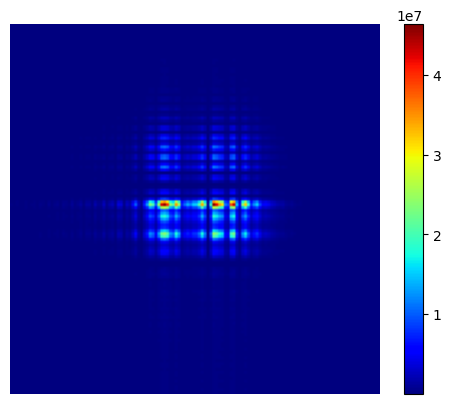

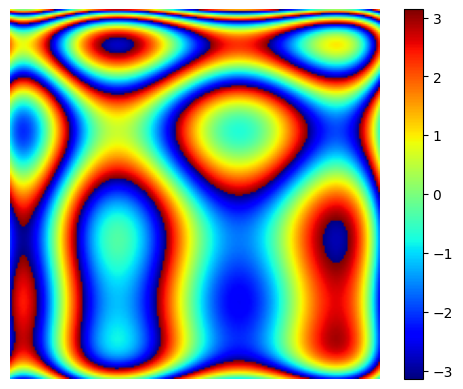

In [ ]:
# coef = [0.0, 0.0, 0.0, -1.2514339588855623, 0.0, -0.3144071409557081, -0.8010882969276838, 0.0, 0.0, 1.3111189862683834, 0.35207777395103856, 0.0, 0.0, 0.0, -0.28724129164016254, -1.4398127181549492, 0.0, 0.0, 0.0, 0.0, 0.15651562780177164, 1.0270377425221868, 0.0, 0.0, 0.0, 0.0, 0.0, -0.05356897336279265]

print(coef)
theta_x = 0.0e-4
theta_y = 0.0e-4
pupil = make_wavefront_oblique(coef, theta_x, theta_y)
plt.imshow(np.angle(pupil),cmap="jet")
plt.colorbar()
plt.show()
score = ssim_culc2_8_filter(pupil)

now = datetime.now()
timestamp = now.strftime("%Y%m%d_%H%M%S")
print(timestamp)
save_dir = f"./CoolMomentumSPGD_starthenka_{theta_x},{theta_y}_{timestamp}"
save_images = f"{save_dir}/images"
if not os.path.exists(save_images):
  os.makedirs(save_images)

print(coef)
pupil = make_wavefront_oblique(coef, theta_x, theta_y)
pupil0 = make_wavefront(coef)
rms = rms_calculate(pupil0)
rot_A = np.array(tfa.rotate(obA, tf.constant(-1.0*0)))
rot_P = np.array(tfa.rotate(obP, tf.constant(-1.0*0)))
object_img = rot_A * np.exp(rot_P * 1j)
object_imgFT = np.fft.fftshift(np.fft.fft2(object_img))
imSeqLowFT = object_imgFT * pupil
exp_field = np.fft.ifft2(np.fft.ifftshift(imSeqLowFT))
exp_intensity = np.abs(exp_field)**2
img_out = np.sqrt(exp_intensity)
img_out = img_out
imgName = f"start_img_{score}.tif"
filename = os.path.join(save_dir, imgName)
plt.imshow(img_out,cmap='gray',vmin=0, vmax=2.0)
plt.xticks([])
plt.yticks([])
plt.savefig(filename, dpi = 300, format= 'tiff')
plt.show()
exp_field = np.fft.fftshift(np.fft.fft2(np.fft.fftshift(pupil)))
exp_intensity = np.abs(exp_field)**2
imgName = "start_psf.tif"
filename = os.path.join(save_dir, imgName)
plt.imshow(exp_intensity[imax//2-64:imax//2+64,imax//2-64:imax//2+64], cmap="jet",vmin=0, vmax=1416468496.0)
plt.axis("off")
plt.colorbar()
plt.savefig(filename, dpi = 300, format= 'tiff')
plt.show()
imgName = "start_psf2.tif"
filename = os.path.join(save_dir, imgName)
plt.imshow(exp_intensity[imax//2-64:imax//2+64,imax//2-64:imax//2+64], cmap="jet")
plt.axis("off")
plt.colorbar()
plt.savefig(filename, dpi = 300, format= 'tiff')
plt.show()
imgName = f"start_wavefront_{rms}.tif"
filename = os.path.join(save_dir, imgName)
pupil2 = pupil0[imax//2-int(aperture//2):imax//2+int(aperture//2),imax//2-int(aperture//2):imax//2+int(aperture//2)]
plt.imshow(np.angle(pupil2), cmap="jet", vmin=-np.pi, vmax=np.pi)
plt.axis("off")
plt.colorbar()
plt.savefig(filename, dpi = 300, format= 'tiff')
plt.show()

In [ ]:
CoolMomentumSPGD(limit, iterations = 100)

print(coef)
pupil = make_wavefront_oblique(coef, theta_x, theta_y)
pupil0 = make_wavefront(coef)
rms = rms_calculate(pupil0)
score = ssim_culc2_8_filter(pupil)
rot_A = np.array(tfa.rotate(obA, tf.constant(-1.0*0)))
rot_P = np.array(tfa.rotate(obP, tf.constant(-1.0*0)))
object_img = rot_A * np.exp(rot_P * 1j)
object_imgFT = np.fft.fftshift(np.fft.fft2(object_img))
imSeqLowFT = object_imgFT * pupil
exp_field = np.fft.ifft2(np.fft.ifftshift(imSeqLowFT))
exp_intensity = np.abs(exp_field)**2
img_out = np.sqrt(exp_intensity)
img_out = img_out
imgName = f"img_{score}.tif"
filename = os.path.join(save_dir, imgName)
plt.imshow(img_out,cmap='gray',vmin=0, vmax=2.0)
plt.xticks([])
plt.yticks([])
plt.savefig(filename, dpi = 300, format= 'tiff')
plt.show()
exp_field = np.fft.fftshift(np.fft.fft2(np.fft.fftshift(pupil)))
exp_intensity = np.abs(exp_field)**2
imgName = "psf.tif"
filename = os.path.join(save_dir, imgName)
plt.imshow(exp_intensity[imax//2-64:imax//2+64,imax//2-64:imax//2+64], cmap="jet",vmin=0, vmax=1416468496.0)
plt.axis("off")
plt.colorbar()
plt.savefig(filename, dpi = 300, format= 'tiff')
plt.show()
imgName = "psf2.tif"
filename = os.path.join(save_dir, imgName)
plt.imshow(exp_intensity[imax//2-64:imax//2+64,imax//2-64:imax//2+64], cmap="jet")
plt.axis("off")
plt.colorbar()
plt.savefig(filename, dpi = 300, format= 'tiff')
plt.show()
imgName = f"wavefront_{rms}.tif"
filename = os.path.join(save_dir, imgName)
pupil2 = pupil0[imax//2-int(aperture//2):imax//2+int(aperture//2),imax//2-int(aperture//2):imax//2+int(aperture//2)]
plt.imshow(np.angle(pupil2), cmap="jet", vmin=-np.pi, vmax=np.pi)
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.savefig(filename, dpi = 300, format= 'tiff')
plt.show()
save_gif(save_dir,flame=100)

step0
diffusion-0.0006105601787567139
0.16283531
diffusion0.0804545134305954
0.17834483
diffusion-0.007959514856338501
0.18737756
diffusion0.04275023937225342
0.19580509
diffusion-0.017383426427841187
0.20004943
diffusion-0.06417113542556763
0.21050335
diffusion-0.010926887392997742
0.21451396
diffusion-0.03497314453125
0.22002055
diffusion0.0010517686605453491
0.22269998
diffusion0.016464844346046448
0.22356242
diffusion0.03933645784854889
0.22726314
diffusion0.040939003229141235
0.23190165
diffusion-0.03808748722076416
0.23795094
diffusion-0.02148030698299408
0.24092232
diffusion0.005445942282676697
0.24235238
diffusion-0.023908615112304688
0.24349825
diffusion0.008257761597633362
0.24371174
diffusion-0.005677998065948486
0.2438456
diffusion-0.021314695477485657
0.24496444


KeyboardInterrupt: 